In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import geopandas as gpd

In [ ]:
import pandas as pd

df = pd.read_csv('pittsburghArrest.csv')

df = df[['AGE', 'INCIDENTNEIGHBORHOOD']]

df = df.dropna(subset=['AGE', 'INCIDENTNEIGHBORHOOD'])

df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df = df.dropna(subset=['AGE'])

def categorize_age(age):
    return 'under_18' if age < 18 else 'over_18'

df['AGE_CATEGORY'] = df['AGE'].apply(categorize_age)

summary = df.groupby('INCIDENTNEIGHBORHOOD').agg(
    total_crimes=('AGE', 'count'),
    under_18=('AGE_CATEGORY', lambda x: (x == 'under_18').sum()),
    over_18=('AGE_CATEGORY', lambda x: (x == 'over_18').sum())
).reset_index()

summary.to_csv('summaryPittCrime.csv', index=False)

汇总完成，已保存为 summaryPittCrime.csv


In [ ]:
import pandas as pd

df = pd.read_csv("pittsburghParks.csv", usecols=["type", "neighborhood"])

df = df.dropna(subset=["type", "neighborhood"])

df["is_park"] = df["type"] == "Park"

summary = df.groupby("neighborhood").agg(
    park_count=("is_park", lambda x: x.sum()),
    non_park_count=("is_park", lambda x: (~x).sum())
).reset_index()

summary.to_csv("summaryPittPark.csv", index=False)



In [ ]:
import pandas as pd

df = pd.read_csv("pittsburghFacility.csv", usecols=["neighborhood"])

df = df.dropna(subset=["neighborhood"])

summary = df.groupby("neighborhood").size().reset_index(name="facility_count")

summary.to_csv("summaryPittFacilities.csv", index=False)



In [ ]:

df = pd.read_csv("pittsburghSteps.csv")

df = df[["neighborhood", "length", "number_of_steps"]]
df = df.dropna(subset=["neighborhood", "length", "number_of_steps"])

df_with_steps = df[df["number_of_steps"] > 0]
df_no_steps = df[df["number_of_steps"] == 0]

grouped_steps = df_with_steps.groupby("neighborhood").agg({
    "length": "sum",
    "number_of_steps": "sum"
}).rename(columns={
    "length": "Total_Length_With_Steps",
    "number_of_steps": "Total_Steps"
})

grouped_steps["Length_per_Step"] = grouped_steps["Total_Length_With_Steps"] / grouped_steps["Total_Steps"]

grouped_no_steps = df_no_steps.groupby("neighborhood").agg({
    "length": "sum"
}).rename(columns={"length": "Zero_Steps_Total_Length"})

final_df = grouped_steps.join(grouped_no_steps, how="outer").fillna(0)

final_df = final_df.reset_index().rename(columns={"neighborhood": "NEIGHBORHOOD"})

final_df.to_csv("summaryPittSteps.csv", index=False)

In [ ]:
df = pd.read_csv("pittsburghTrees.csv")

tree_count = df.groupby("neighborhood").size().reset_index(name="tree_count")

tree_count.to_csv("summaryPittTrees.csv", index=False)

In [19]:
df = pd.read_csv("pittsburghEnrollment.csv")

df["neighborhood"] = df["neighborhood"].str.strip()
df["neighborhood"] = df["neighborhood"].str.upper()

summary = df.groupby("neighborhood")["enrolled_students"].sum().reset_index()

summary.rename(columns={
    "neighborhood": "NEIGHBORHOOD",
    "enrolled_students": "TOTAL_STUDENTS"
}, inplace=True)

summary.to_csv("summaryPittStudents.csv", index=False)


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("../GeopandasTest/hood.geojson")
# print(gdf["hood"].unique())
# print(gdf["Shape__Area"].head())
print(gdf.columns)

In [ ]:
import pandas as pd

arrest_df = pd.read_csv("summaryPittCrime.csv")
park_df = pd.read_csv("summaryPittPark.csv")
fac_df = pd.read_csv("summaryPittFacilities.csv")
step_df = pd.read_csv("summaryPittSteps.csv")
tree_df = pd.read_csv("summaryPittTrees.csv")
stu_df = pd.read_csv("summaryPittStudents.csv")

for df in [arrest_df, park_df, fac_df, step_df, tree_df, stu_df]:
    df["NEIGHBORHOOD"] = df["NEIGHBORHOOD"].str.strip().str.upper()

arrest_neigh = set(arrest_df["NEIGHBORHOOD"])
fac_neigh = set(fac_df["NEIGHBORHOOD"])
step_neigh = set(step_df["NEIGHBORHOOD"])
park_neigh = set(park_df["NEIGHBORHOOD"])
tree_neigh = set(tree_df["NEIGHBORHOOD"])
stu_neigh = set(stu_df["NEIGHBORHOOD"])

core_common = arrest_neigh & fac_neigh & step_neigh & tree_neigh & stu_neigh

all_core = arrest_neigh | fac_neigh | step_neigh | tree_neigh | stu_neigh
missing_core = all_core - core_common

if missing_core:
    print("The following neighborhoods are missing from at least one dataset(not in park):")
    for name in sorted(missing_core):
        print("-", name)

arrest_df = arrest_df[arrest_df["NEIGHBORHOOD"].isin(core_common)]
fac_df = fac_df[fac_df["NEIGHBORHOOD"].isin(core_common)]
step_df = step_df[step_df["NEIGHBORHOOD"].isin(core_common)]
tree_df = tree_df[tree_df["NEIGHBORHOOD"].isin(core_common)]
stu_df = stu_df[stu_df["NEIGHBORHOOD"].isin(core_common)]

park_df = park_df[park_df["NEIGHBORHOOD"].isin(core_common)]

merged = arrest_df.merge(fac_df, on="NEIGHBORHOOD")
merged = merged.merge(step_df, on="NEIGHBORHOOD")
merged = merged.merge(park_df, on="NEIGHBORHOOD", how="left")
merged = merged.merge(tree_df, on="NEIGHBORHOOD", how="left")
merged = merged.merge(stu_df, on="NEIGHBORHOOD", how="left")

merged = merged.fillna(0)

merged.to_csv("summaryPitt_ALL_MERGED.csv", index=False)


⚠️ 以下街区在部分数据集中缺失（不包括park），将不会被纳入合并：
- ALLEGHENY WEST
- ARLINGTON
- ARLINGTON HEIGHTS
- CENTRAL BUSINESS DISTRICT
- CENTRAL NORTH SIDE
- CHARTIERS CITY
- CHATEAU
- EAST CARNEGIE
- ESPLEN
- FAIRYWOOD
- FRIENDSHIP
- GOLDEN TRIANGLE
- GOLDEN TRIANGLE/CIVIC ARENA
- HAYS
- HOMEWOOD SOUTH
- HOMEWOOD WEST
- MOUNT OLIVER
- MOUNT OLIVER BOROUGH
- MT. OLIVER
- MT. OLIVER BORO
- MT. OLIVER NEIGHBORHOOD
- NEW HOMESTEAD
- NORTH SHORE
- NORTHVIEW HEIGHTS
- OUTSIDE CITY
- OUTSIDE COUNTY
- OUTSIDE STATE
- RIDGEMONT
- SAINT CLAIR
- SOUTH SHORE
- SPRING GARDEN
- ST. CLAIR
- STRIP DISTRICT
- SUMMER HILL
- SWISSHELM PARK
- TROY HILL-HERRS ISLAND
- WILKINSBURG BOROUGH
✅ 合并完成，已导出为 summaryPitt_ALL_MERGED.csv


In [3]:
step_df = pd.read_csv("summaryPitt_ALL_MERGED.csv")
step_df["NEIGHBORHOOD"] = step_df["NEIGHBORHOOD"].str.strip().str.upper()

geo = gpd.read_file("hood.geojson")[["hood", "Shape__Area"]]
geo.rename(columns={"hood": "NEIGHBORHOOD"}, inplace=True)

geo["NEIGHBORHOOD"] = geo["NEIGHBORHOOD"].str.strip().str.upper()
geo = geo.groupby("NEIGHBORHOOD", as_index=False)["Shape__Area"].sum()

geo["NORMALIZED_AREA"] = geo["Shape__Area"] / geo["Shape__Area"].max()
geo["NORMALIZED_AREA"].replace(0, 1e-6, inplace=True)

merged = pd.merge(
    step_df,
    geo[["NEIGHBORHOOD", "NORMALIZED_AREA"]],
    on="NEIGHBORHOOD",
    how="inner"
)

original_cols = [col for col in step_df.columns if col != "NEIGHBORHOOD"]
unit_data = {}

for col in original_cols:
    unit_col = col + "_UNIT"
    unit_data[unit_col] = merged[col] / merged["NORMALIZED_AREA"]

unit_df = pd.DataFrame(unit_data)
result = pd.concat([merged[["NEIGHBORHOOD"]], unit_df], axis=1)
result.to_csv("summaryPitt_ALL_MERGED_UNIT.csv", index=False)

/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_59383/418615379.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
# import pandas as pd
# import geopandas as gpd

# step_df = pd.read_csv("summaryPitt_ALL_MERGED.csv")
# step_df["NEIGHBORHOOD"] = step_df["NEIGHBORHOOD"].str.strip().str.upper()

# geo = gpd.read_file("hood.geojson")[["hood", "Shape__Area"]]
# geo.rename(columns={"hood": "NEIGHBORHOOD"}, inplace=True)
# geo["NEIGHBORHOOD"] = geo["NEIGHBORHOOD"].str.strip().str.upper()

# geo["NORMALIZED_AREA"] = geo["Shape__Area"] / geo["Shape__Area"].max()

# merged = pd.merge(step_df, geo[["NEIGHBORHOOD", "NORMALIZED_AREA"]], on="NEIGHBORHOOD", how="inner")

# columns_to_keep = [
#     "total_crimes", "under_18", "over_18"
# ]

# unit_data = {}

# for col in step_df.columns:
#     if col == "NEIGHBORHOOD":
#         continue
#     if col in columns_to_keep:
#         unit_data[col + "_UNIT"] = merged[col]
#     else:
#         unit_data[col + "_UNIT"] = merged[col] / merged["NORMALIZED_AREA"].replace(0, 1e-6)

# unit_df = pd.DataFrame(unit_data)
# result = pd.concat([merged[["NEIGHBORHOOD"]], unit_df], axis=1)

# result.to_csv("summaryPitt_ALL_MERGED_UNIT_MIXED.csv", index=False)


✅ 成功生成 summaryPitt_ALL_MERGED_UNIT_MIXED.csv（大小写问题搞定啦～）


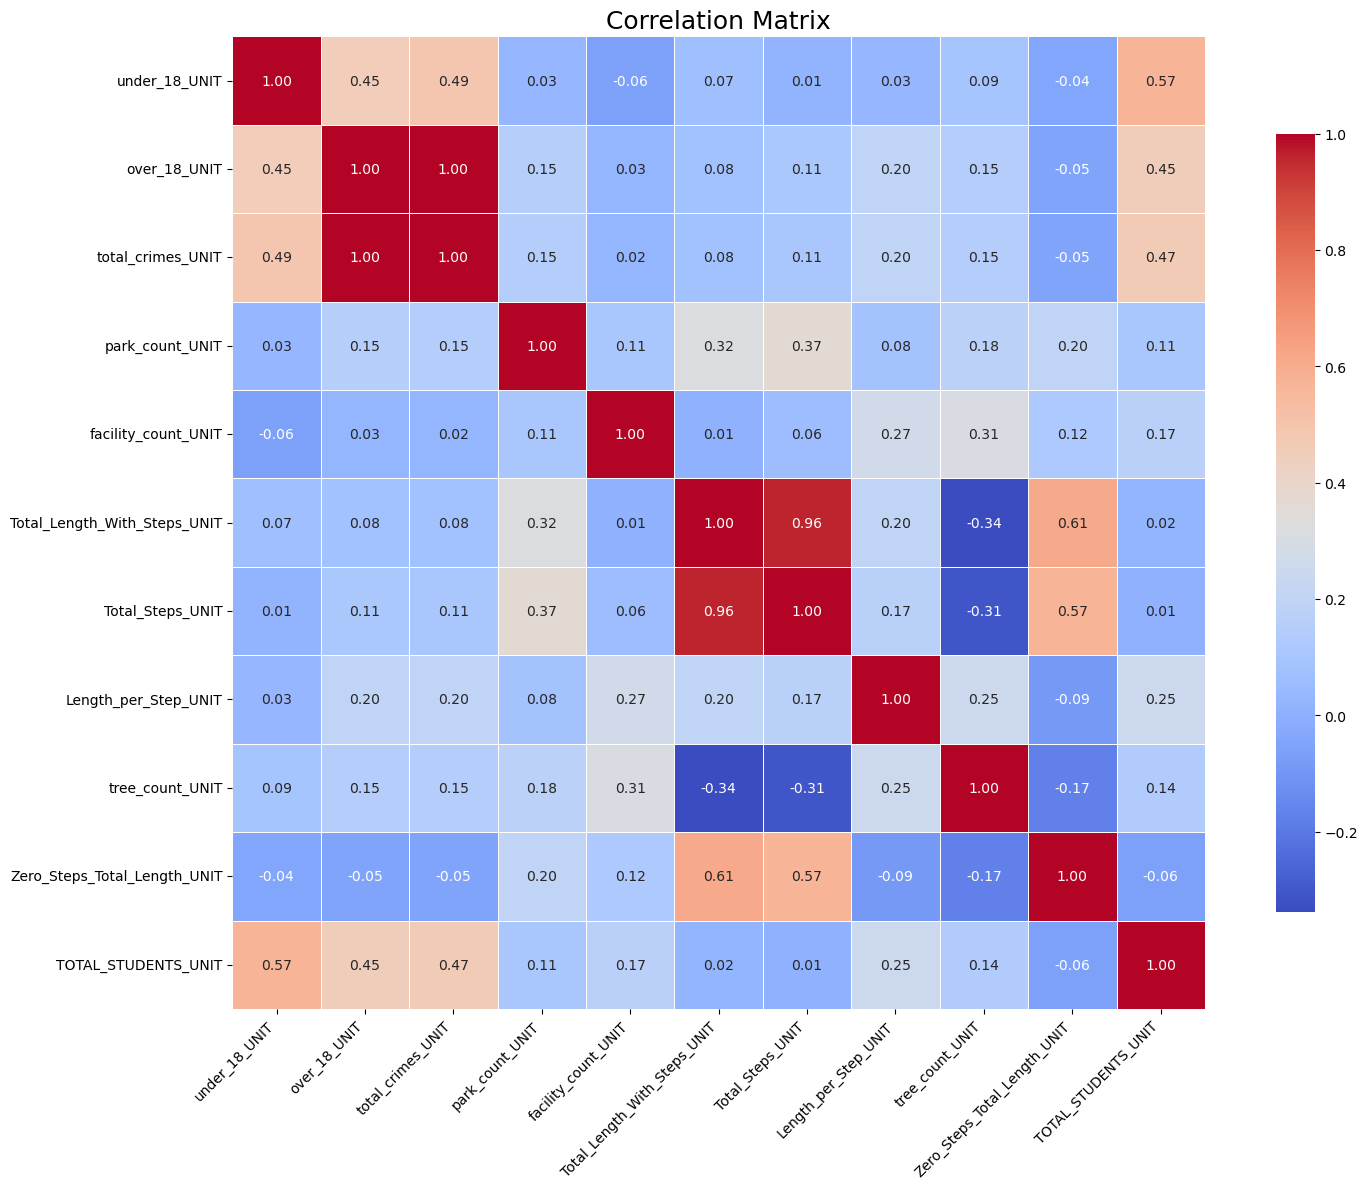

In [6]:
df = pd.read_csv("summaryPitt_ALL_MERGED_UNIT.csv")

columns_to_analyze = [
    "under_18_UNIT", "over_18_UNIT",
    "total_crimes_UNIT",
    "park_count_UNIT",

    "facility_count_UNIT",

    "Total_Length_With_Steps_UNIT", "Total_Steps_UNIT", 
    "Length_per_Step_UNIT",
    "tree_count_UNIT",
    "Zero_Steps_Total_Length_UNIT",
    "TOTAL_STUDENTS_UNIT"
]
# columns_to_analyze = [
#     "Under_18_Count", "Over_18_Count",
#     "Total_Count",
#     "Park_Count",
#     # "Park", "Not_Park", "Park_Global_Percent", "Not_Park_Global_Percent",

#     "Total_Facilities",

#     "Total_Length_With_Steps", "Total_Steps", 
#     "Length_per_Step",
#     "tree_count",
#     "Zero_Steps_Total_Length",
#     "TOTAL_STUDENTS"
# ]

correlation_matrix = df[columns_to_analyze].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Correlation Matrix", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("correlation_matrix.png", dpi=300)
plt.show()

In [4]:
df = pd.read_csv("summaryPitt_ALL_MERGED_UNIT.csv")

columns_to_analyze = [
    "under_18_UNIT", "over_18_UNIT",
    "total_crimes_UNIT",
    "park_count_UNIT",

    "facility_count_UNIT",

    "Total_Length_With_Steps_UNIT", "Total_Steps_UNIT", 
    "Length_per_Step_UNIT",
    "tree_count_UNIT",
    "Zero_Steps_Total_Length_UNIT",
    "TOTAL_STUDENTS_UNIT"
]
# columns_to_analyze = [
#     "Under_18_Count", "Over_18_Count",
#     "Total_Count",
#     "Park_Count",
#     # "Park", "Not_Park", "Park_Global_Percent", "Not_Park_Global_Percent",

#     "Total_Facilities",

#     "Total_Length_With_Steps", "Total_Steps", 
#     "Length_per_Step",
#     "tree_count",
#     "Zero_Steps_Total_Length",
#     "TOTAL_STUDENTS"
# ]

# 计算相关矩阵
correlation_matrix = df[columns_to_analyze].corr()
import plotly.express as px

# 使用 plotly 创建热图
fig = px.imshow(correlation_matrix, 
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                color_continuous_scale="RdBu_r",  # 选择渐变色调
                title="Correlation Matrix of Various Units",
                zmin=-1, zmax=1,  # 设置颜色的范围
                width=800, height=600)

# 更新布局
fig.update_layout(
    title_font=dict(size=24, color="darkblue"),
    xaxis_title="Variables",
    yaxis_title="Variables",
    xaxis=dict(tickangle=45, tickfont=dict(size=14, color="gray")),
    yaxis=dict(tickfont=dict(size=14, color="gray")),
    plot_bgcolor="white",  # 背景颜色
    paper_bgcolor="white",  # 整体背景颜色
    margin=dict(t=50, b=50, l=50, r=50),  # 调整边距
)

# 显示图形
fig.show()

# 保存为静态图像
fig.write_image("correlation_matrix_plotly.png", scale=3)

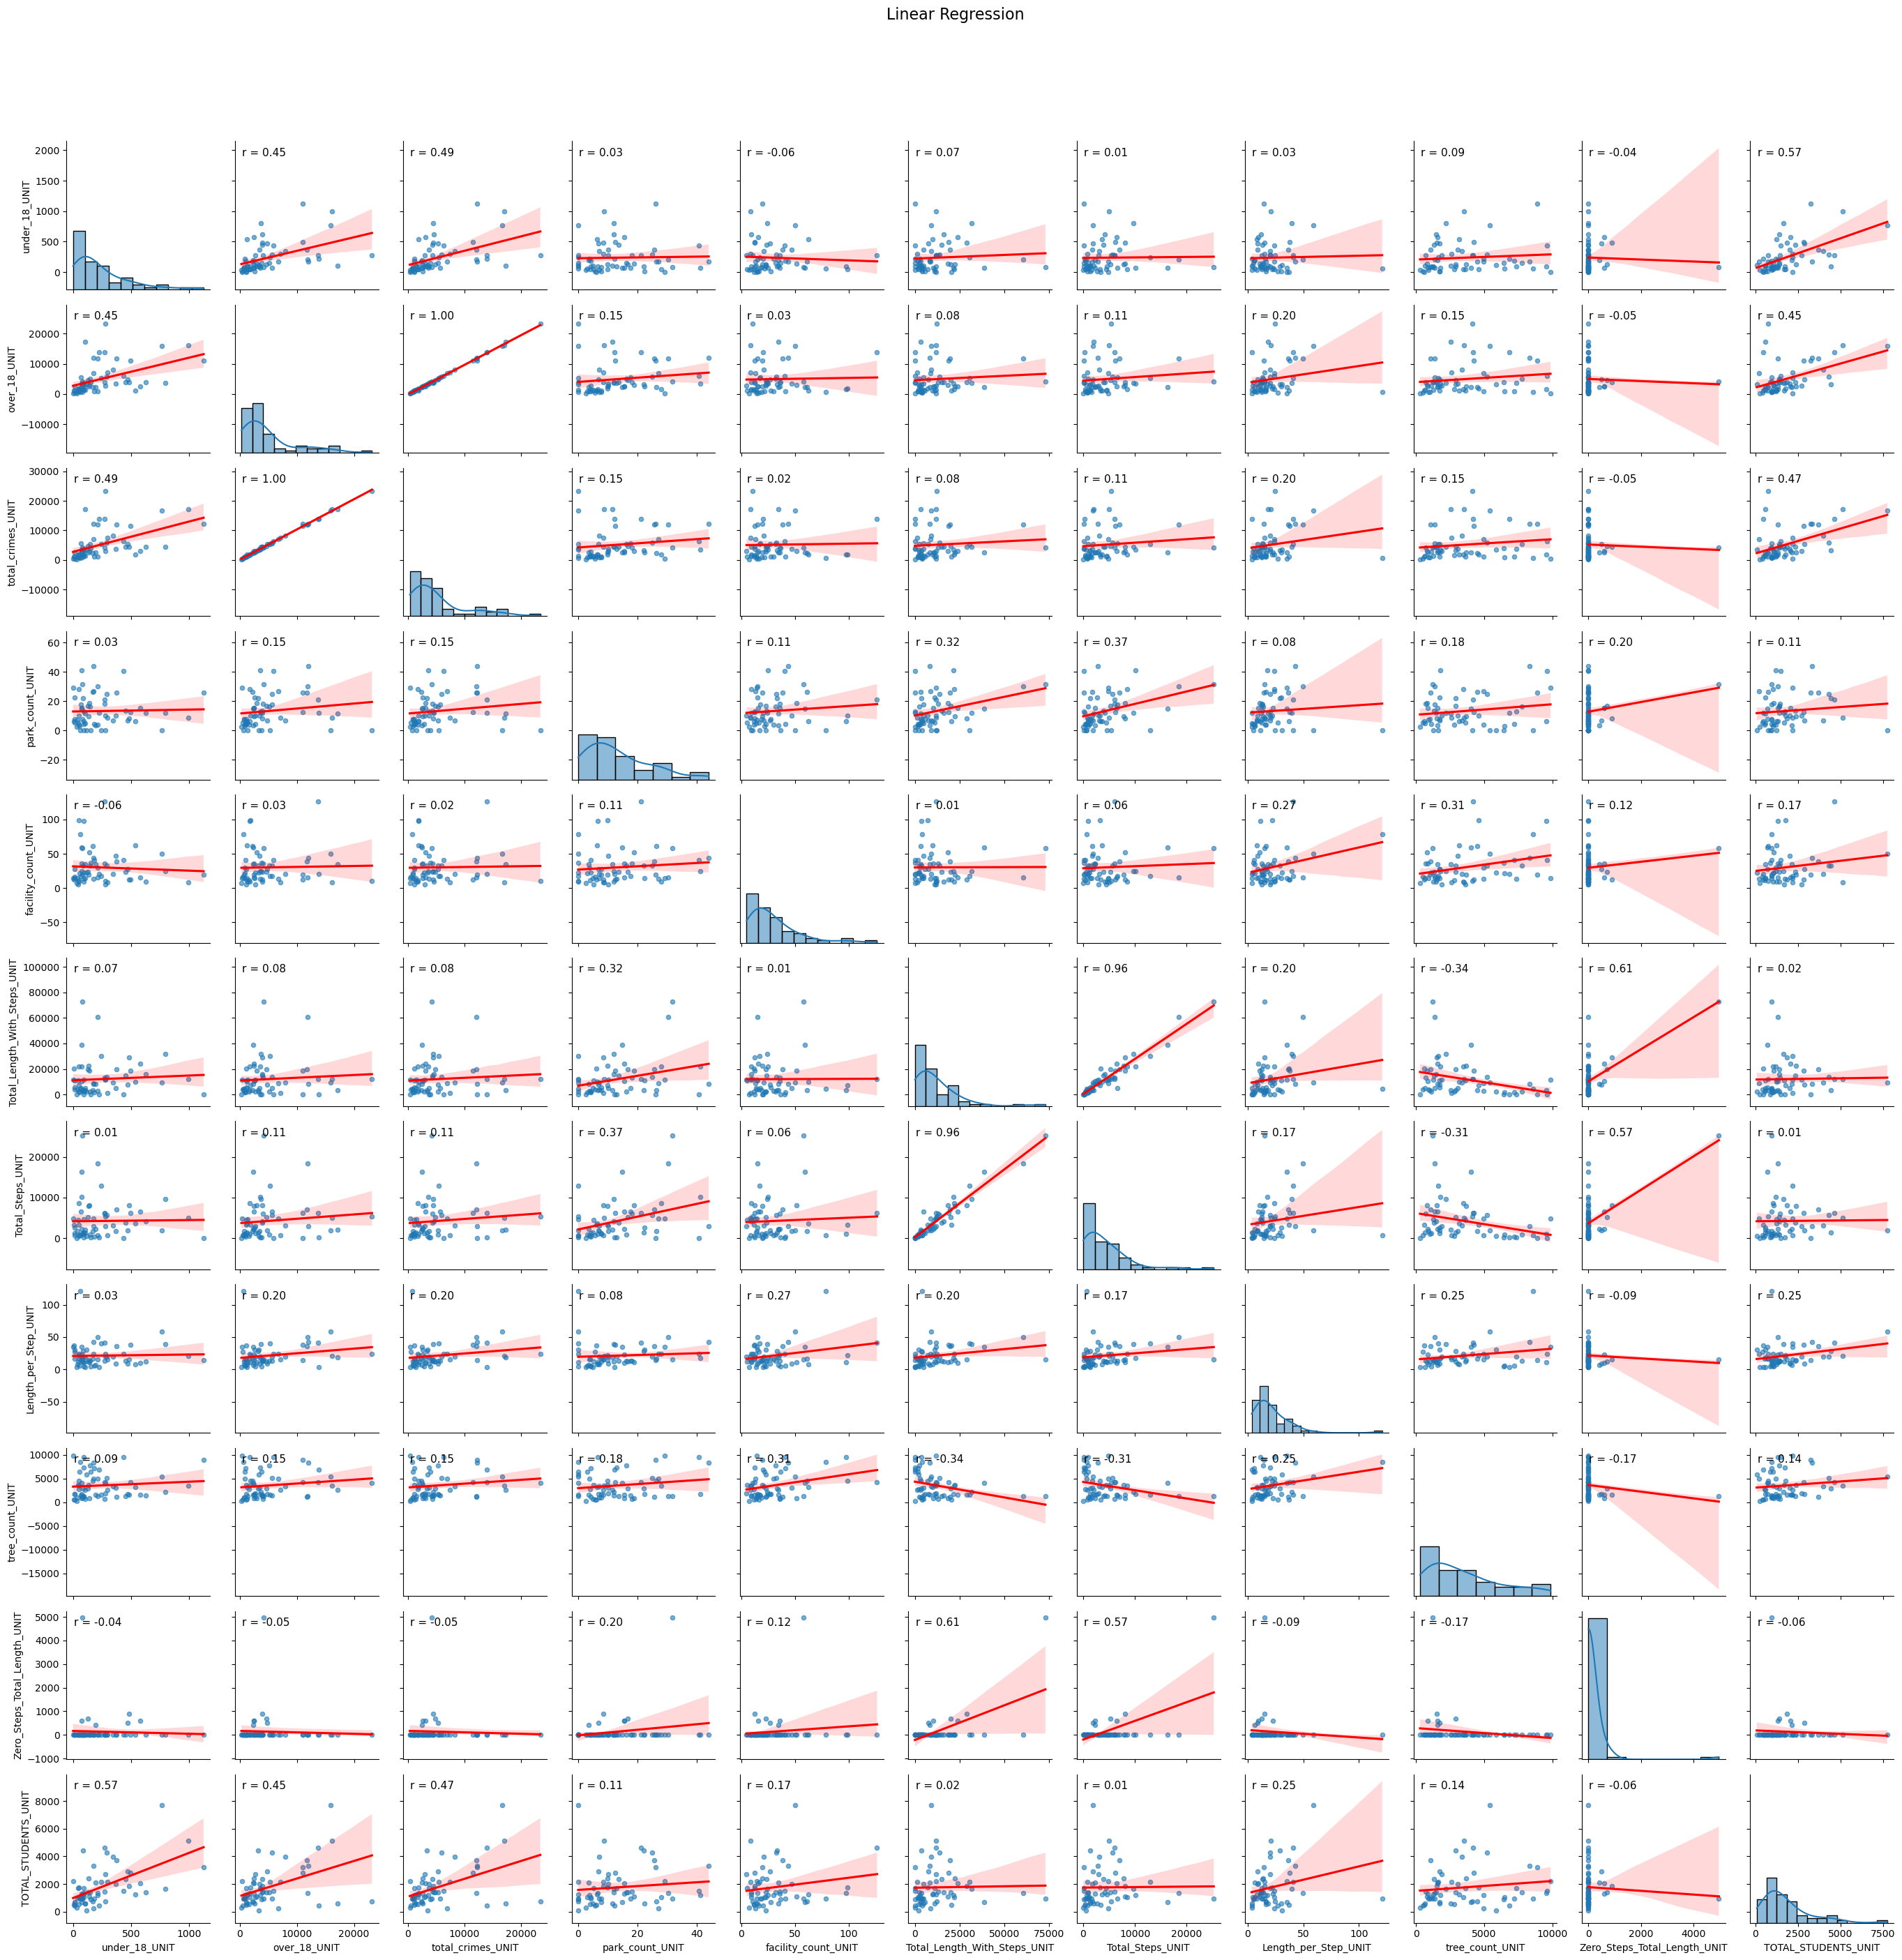

In [5]:
data = df[columns_to_analyze].copy()

def regplot_with_r(x, y, **kwargs):
    ax = kwargs.get("ax", plt.gca())
    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={"s": 20, "alpha": 0.6},
                line_kws={"color": "red"})
    r, _ = pearsonr(x, y)
    ax.annotate(f"r = {r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                fontsize=11, color='black')

g = sns.PairGrid(data, height=2.5)

g.map_lower(regplot_with_r)
g.map_upper(regplot_with_r)

g.map_diag(sns.histplot, kde=True)

plt.suptitle("Linear Regression", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig("pairwise_full_regplot_r.png", dpi=300)
plt.show()
